In [32]:
import glob,os
import librosa
import numpy as np

import matplotlib.pyplot as plt   
import IPython.display as ipd
from matplotlib import cm

import scipy
import librosa as rs
from scipy import io
import random
import json

# force re-import
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
root_rir    = "/home/data2/kbh/MIDR___Multi-Channel_Impulse_Response_Database/"
root_speech = "/home/nas/DB/CHiME4/data/audio/16kHz/isolated/tr05_org/"
root_noise  = "/home/nas/DB/DEMAND/dataset/"

In [34]:
## PARAM
SNR_max = 20
SNR_min = 0

SIR_max = 10
SIR_min = -5

scale_dB_max = 15
scale_dB_min = -40

len_data = 16000*5
ratio_test = 0.25

n_train = 10000
n_test = 1000

list_room_test = []
list_room_test.append("Impulse_response_Acoustic_Lab_Bar-Ilan_University_(Reverberation_0.160s)_4-4-4-8-4-4-4")
list_room_test.append("Impulse_response_Acoustic_Lab_Bar-Ilan_University_(Reverberation_0.360s)_4-4-4-8-4-4-4")
list_room_test.append("Impulse_response_Acoustic_Lab_Bar-Ilan_University_(Reverberation_0.610s)_4-4-4-8-4-4-4")

list_speech = glob.glob(os.path.join(root_speech,"*.wav"))
random.shuffle(list_speech)
idx_split = int(len(list_speech)*ratio_test)
list_speech_test = list_speech[:idx_split]
print("speech test : {}".format(len(list_speech_test)))

list_noise = glob.glob(os.path.join(root_noise,"**","*.wav"))
random.shuffle(list_noise)
idx_split = int(len(list_noise)*ratio_test)
list_noise_test = list_noise[:idx_split]
print("noise test : {}".format(len(list_noise_test)))

speech test : 1784
noise test : 72


In [37]:
def sample(is_train=True) : 
    
    if is_train : 
        dir_RIR = random.sample(list_room_train,1)[0]
    else :
        dir_RIR = random.sample(list_room_test,1)[0]

    RT60 = float(dir_RIR[65:70])
    mic_array = dir_RIR[73:86]
    mic_on_left = bool(random.getrandbits(1))

    list_RIR = glob.glob(os.path.join(root_rir,dir_RIR,"*.mat"))

    is_2m = bool(random.getrandbits(1))

    if is_2m : 
        list_RIR = [x for x in list_RIR if "2m" in x.split('/')[-1] ]
    else : 
        list_RIR = [x for x in list_RIR if "1m" in x.split('/')[-1] ]

    idx_angle = np.random.choice(13,2,replace=False)

    RIR_speech = list_RIR[idx_angle[0]]
    RIR_interf = list_RIR[idx_angle[1]]

    angle = RIR_speech.split("_")[-1]
    angle = float(angle.split(".")[0])

    ## Scale

    SNR = np.random.uniform(low=SNR_min, high=SNR_max)
    SIR = np.random.uniform(low=SIR_min, high=SIR_max)
    scale_dB = np.random.uniform(low=scale_dB_min, high=scale_dB_max)

    ## audio
    if is_train :
        idx_speech = np.random.choice(len(list_speech_train),2,replace=False)
        path_speech = list_speech_train[idx_speech[0]]
        path_interf = list_speech_train[idx_speech[1]]
        path_noise = random.sample(list_noise_train,1)[0]
    else :
        idx_speech = np.random.choice(len(list_speech_test),2,replace=False)
        path_speech = list_speech_test[idx_speech[0]]
        path_interf = list_speech_test[idx_speech[1]]
        path_noise = random.sample(list_noise_test,1)[0]

    label = {}
    label["RT60"] = RT60
    label["mic_array"] = mic_array
    label["mic_on_left"] = mic_on_left
    label["is_2m"] = is_2m
    label["RIR_speech"] = RIR_speech
    label["RIR_interf"] = RIR_interf
    label["SIR"] = SIR
    label["SNR"] = SNR
    label["scale_dB"] = scale_dB
    label["angle"] = angle
    label["path_speech"] = path_speech
    label["path_interf"] = path_interf
    label["path_noise"] = path_noise

    return label, list_RIR

def mix(
        SIR,
        SNR,
        len_data,
        scale_dB, 
        mic_on_left,
        path_RIR_speech,
        path_RIR_interf,
        path_RIR_noise,
        path_speech,
        path_interf,
        path_noise
    ) :

    ## RIR and target
    rir_speech = io.loadmat(path_RIR_speech)["impulse_response"]
    if mic_on_left : 
        rir_speech = rir_speech[:,:4]
    else :
        rir_speech = rir_speech[:,4:]
    speech,_ = rs.load(path_speech,sr=16000,mono=False)
    
    plt.figure()
    plt.plot(rir_speech[:,0])
    spec2plot(rir_speech[:,0])

    s = []
    for i in range(4) :
        #s.append(scipy.signal.fftconvolve(speech,rir_speech[:,i]))
        s.append(scipy.signal.convolve(speech,rir_speech[:,i]))

    s = np.stack(s)    
    if s.shape[1] < len_data : 
        s = np.pad(s,(0,len_data-s.shape[1]))
    else :
        idx_clip = np.random.randint(0,s.shape[1]-len_data)
        s = s[:,:len_data]

    clean = s[0]
    clean_rms = (clean ** 2).mean() ** 0.5

    ## interf
    rir_interf = io.loadmat(path_RIR_interf)["impulse_response"]
    if mic_on_left : 
        rir_interf = rir_interf[:,:4]
    else :
        rir_interf = rir_interf[:,4:]
    interf,_ = rs.load(path_interf,sr=16000,mono=False)

    v = []
    for i in range(4) :
        #v.append(scipy.signal.fftconvolve(interf,rir_interf[:,i]))
        v.append(scipy.signal.convolve(interf,rir_interf[:,i]))
    v = np.stack(v)

    if v.shape[1] < len_data : 
        v = np.pad(v,(0,len_data-v.shape[1]))
    else :
        v = v[:,:len_data]

    interf = v[0]
    # SIR

    interf_rms = (interf ** 2).mean() ** 0.5
    snr_scalar = clean_rms / (10 ** (SIR / 20)) / (interf_rms + 1e-13)
    v *= snr_scalar

    ## Mix
    #x = s + v + d

    # no noise
    x = s + v

    # dB Management
    # resacle noisy RMS
    rms = np.sqrt(np.mean(x ** 2))
    scalar = 10 ** (scale_dB / 20) / (rms + 1e-13)
    x *= scalar
    clean *= scalar

    if np.any(np.abs(x) > 0.999)  : 
        noisy_scalar = np.max(np.abs(x)) / (0.99 - 1e-13)  # same as divide by 1
        x /= noisy_scalar
        clean /= noisy_scalar
        
    #x = rs.resample(x,48000,16000)
    #clean = rs.resample(clean,48000,16000)

    return x, clean

def generate(idx,is_train) : 
    label,RIR_diffuse = sample(is_train)

    x,s = mix(
        SIR = label["SIR"],
        SNR     = label["SNR"],
        len_data = len_data,
        scale_dB = label["scale_dB"], 
        mic_on_left = label["mic_on_left"],
        path_RIR_speech = label["RIR_speech"],
        path_RIR_interf =  label["RIR_interf"],
        path_RIR_noise = RIR_diffuse,
        path_speech = label["path_speech"],
        path_interf = label["path_interf"],
        path_noise = label["path_noise"]
    )
    return x,s,label
def spec2plot(data):
    data = rs.stft(data,n_fft=512)
    mag = np.abs(data)
    mag = 10*np.log(mag)
    fig, ax = plt.subplots()
    im = plt.imshow(mag, cmap=cm.jet, aspect='auto',origin='lower')
    plt.colorbar(im)
    plt.clim(-80,20)
    
    plt.xlabel('Time')
    plt.ylabel('Freq')
    
    fig.canvas.draw()
    plt.show()

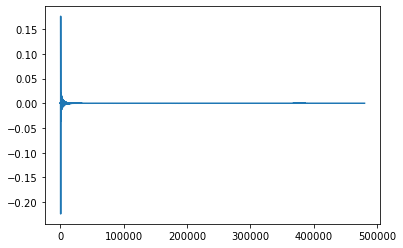

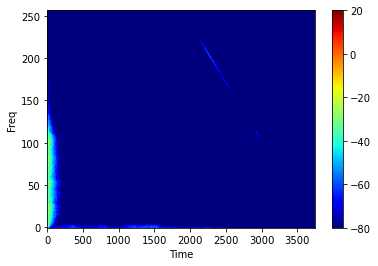

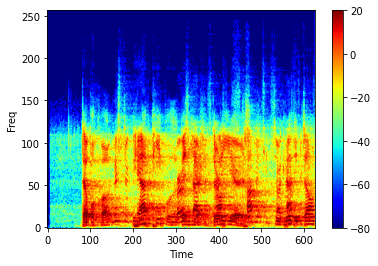

In [38]:
x,s,label = generate(0,is_train=False)


spec2plot(x[0])

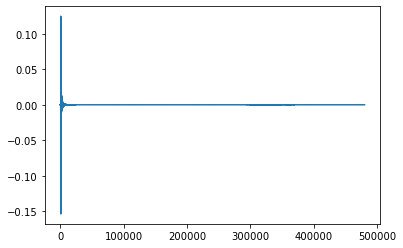

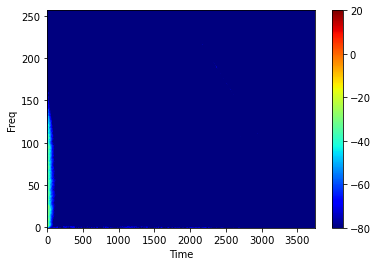

/tmp/ipykernel_6870/2185668975.py:149: FutureWarning: Pass orig_sr=48000, target_sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  x = rs.resample(x,48000,16000)
/tmp/ipykernel_6870/2185668975.py:150: FutureWarning: Pass orig_sr=48000, target_sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  clean = rs.resample(clean,48000,16000)


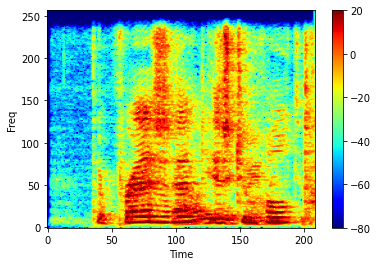

In [36]:
x,s,label = generate(0,is_train=False)


spec2plot(x[0])

In [ ]:

ipd.display(ipd.Markdown('## input'))
ipd.display(ipd.Audio(x, rate=sr))

plt.figure()
plt.plot(x)
plt.title("x")